# 3 урок: Подход динамического ценообразования на основе модели спроса

In [33]:
from IPython.display import Image, Math

import pandas as pd
import numpy as np

# Импортируем библиотеки для визуализаци данных
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

# Что будем делать?

- имплементируем подход на основе модели спроса (модель, спрос, оптимизация)
- изучим этапы построения модели спроса
- посмотрим, как на практике строится датасет для предсказания спроса
- выберем простую оптимизацию для решения поставленной задачи

# Задача

Ваша компания - начинающий маркетплейс: разные продавцы выставляют товары на вашей платформе, с каждой продажи вам отчисляется процент (комиссия). Сейчас у вас продается N товаров. Ваша задача - сделать алгоритм динамического ценообразования так, чтобы максимизировать прибыль вашего маркетплейса:
<center>$Margin = commission * price * quantity + discount * price * quantity \rightarrow \max$</center>

- Нужно выставить цены на <b>2 недели</b> вперед с <b>01.07.2021</b> по <b>14.07.2021</b>
- Цены можно менять <b>+/-10%</b> от текущей цены
- Ваше решение будет сравниваться с подходом "оставить текущие цены" (наценка = <b>0%</b>)

### Данные

Данные состоят из 3 таблиц:
- таблица с историей продаж c 01.01.2021 по 30.06.2021
- таблица с меппингом товар - категории + комиссия, отчисляемая за продажу товара
- таблица с информацией о промо и праздниках

<b>sales.parquet</b>

| Колонка        | Пояснение                                                                                |
|----------------|------------------------------------------------------------------------------------------|
| `sku_id`       | stock keeping unit «единица складского учёта» - идентификатор товарной позиции (артикул) |
| `price`        | цена за дату по товару                                                                   |
| `quantity`     | количество проданного товара за дату                                                     |
| `ds`           | дата                                                                                     |

In [34]:
sales_df = pd.read_parquet("./data/sales.parquet")
sales_df["ds"] = sales_df["ds"].astype(str)
sales_df.head()

,sku_id,price,quantity,ds
207,208,1074.0,15391.0,20210101
75,76,1014.0,7.0,20210101
83,84,1456.0,2005.0,20210101
167,168,1014.0,2124.0,20210101
91,92,1032.0,3214.0,20210101


<b>categories.parquet</b>

Часто на маркетплейсах товары распределены по категориям и являются листом в категорийном дереве. Например, самокат Xiaomi входит в категорию "Электрические самокаты" (категория 3 уровня), которая в свою очередь входит в категорию "Самокаты" (категория 2 уровня), которая входит в "Спорт и отдых" (категория 1 уровня)

| Колонка        | Пояснение                                                                                |
|----------------|------------------------------------------------------------------------------------------|
| `sku_id`       | stock keeping unit «единица складского учёта» - идентификатор товарной позиции (артикул) |
| `group_1`      | категория 1 уровня                                                                       |
| `group_2`      | категория 2 уровня                                                                       |
| `commission`   | комиссия с продажи товара                                                                |

In [35]:
categories_df = pd.read_parquet("./data/categories.parquet")
categories_df.head()

,sku_id,group_1,group_2,commission
39429,176,100000,100012,0.10
30387,96,100000,100005,0.12
72710,12,100006,100009,0.12
20484,62,100005,100021,0.10
17120,243,100005,100033,0.12


<b>dates.parquet</b>
| Колонка        | Пояснение                  |
|----------------|----------------------------|
| `promo`        | название промо для даты    |
| `holiday`      | название праздника для даты|
| `ds`           | дата                       |

In [36]:
dates_df = pd.read_parquet("./data/dates.parquet")
dates_df["ds"] = dates_df["ds"].astype(str)
dates_df.head()

,promo,holiday,ds
0,start_of_the_year,Православное Рождество,20210107
1,love,День защитника отечества,20210223
2,love,no,20210212
3,love,no,20210213
4,love,no,20210214


# Подход динамического ценообразования на основе модели спроса

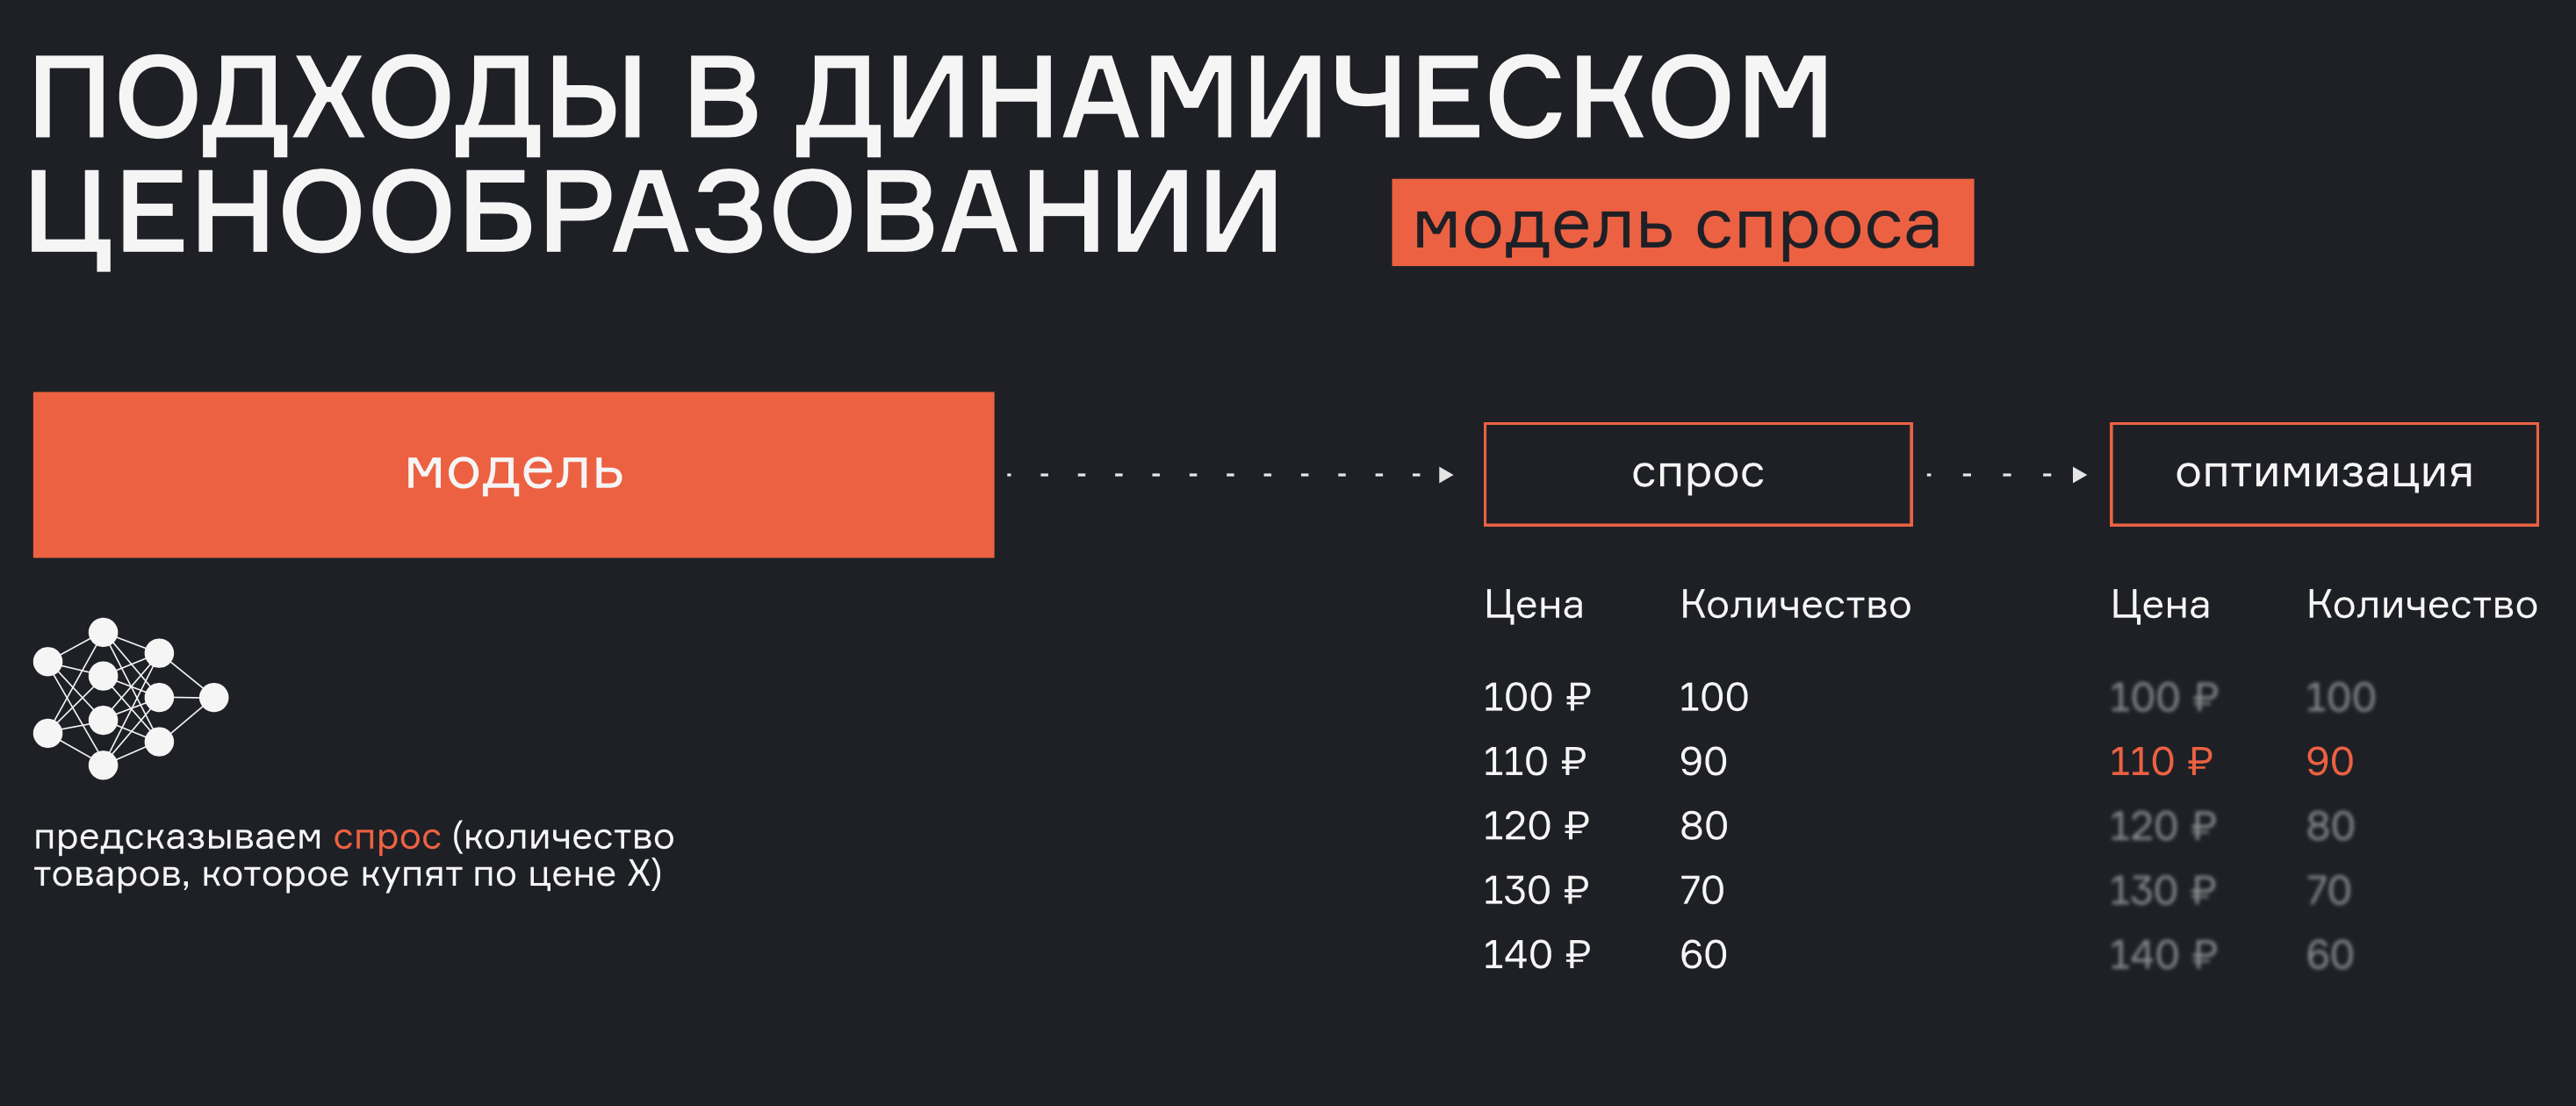

In [37]:
Image("./images/demand_approach.png", width=1000, height=400)

1. Модель
2. Спрос
3. Оптимизация

# 1. Модель

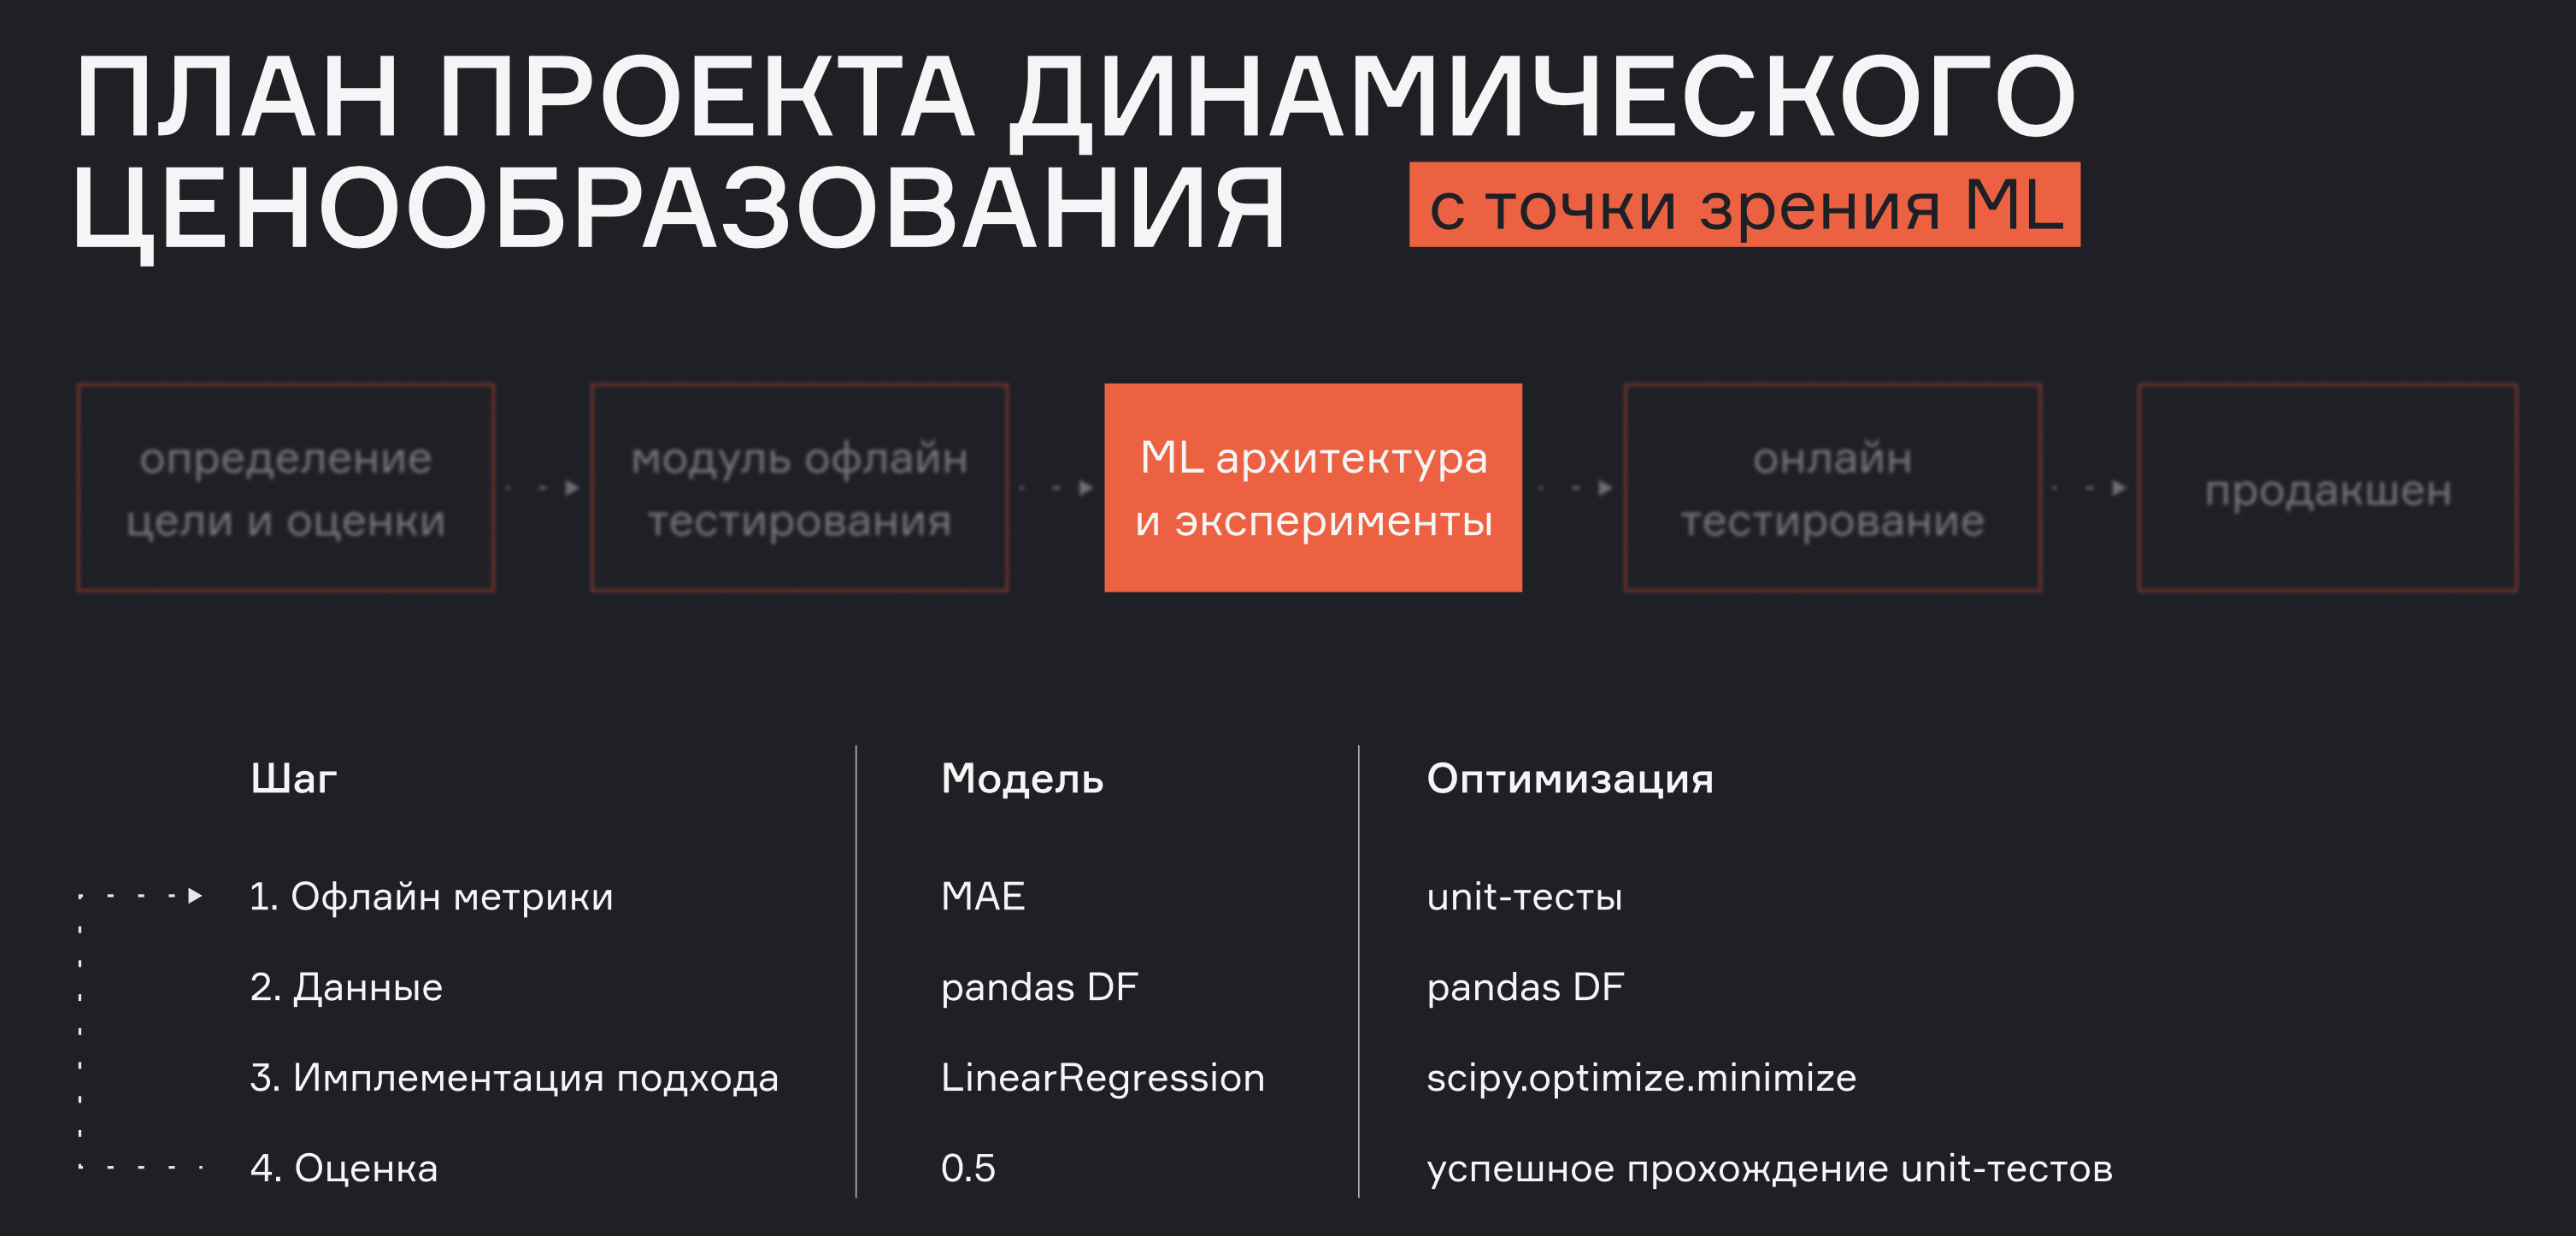

In [38]:
Image("./images/ml_plan.png", width=1000, height=400)

<b>1.1 Офлайн метрики</b>
- Выбор метрик под бизнес-задачу

<b>1.2. Данные</b>
- 1.2.1 EDA (Exploratory data analysis)
- 1.2.2 Сборка данных
- 1.2.3 Преобразование данных
- 1.2.4. Деление на train и test

<b>1.3. Имплементация подхода</b>
- Выбор модели

<b>1.4. Оценка</b>
- 1.4.1 Подсчет офлайн метрик
- 1.4.2 Интерпретация фичей
- 1.4.3 Визуализация предсказаний

## 1.1 Офлайн метрики

Для начала возмем простую метрику MAPE, чтобы оценить, насколько точно мы можем предсказать спрос

In [39]:
display(Math(r"MAPE = \frac{100%}{N}  \sum ^{N}_{i=1} |\frac{y_i-\hat y_i}{y_i}| "))

<IPython.core.display.Math object>

In [40]:
def calculate_mape(
    df: pd.DataFrame,
    true: str = "quantity",
    pred: str = "pred_quantity",
) -> float:
    df_copied = df.copy(deep=True)
    df_copied = df_copied[df_copied[true] > 0]
    df_copied["mape"] = np.abs(df_copied[true] - df_copied[pred]) / df_copied[true]
    return df_copied["mape"].mean()

## 1.2 Данные

### 1.2.1 EDA (Exploratory data analysis)

In [41]:
# Посмотрим на колонки, информацию о пустых значениях и типах данных
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36784 entries, 207 to 75078
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sku_id    36784 non-null  int64  
 1   price     36784 non-null  float64
 2   quantity  36784 non-null  float64
 3   ds        36784 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 1.4+ MB


<font color="red">В данных нет пропусков.</font>

In [42]:
# Посмотрим сводные статистики по числовым переменным
sales_df.describe()

,sku_id,price,quantity
count,36784.000000,36784.000000,3.678400e+04
mean,202.406753,1054.049940,9.969974e+03
std,121.508202,161.952193,5.344129e+04
min,1.000000,1000.000000,0.000000e+00
25%,90.000000,1007.000000,2.050000e+02
50%,203.000000,1018.000000,1.105000e+03
75%,310.000000,1047.000000,4.898000e+03
max,413.000000,8850.000000,3.361143e+06


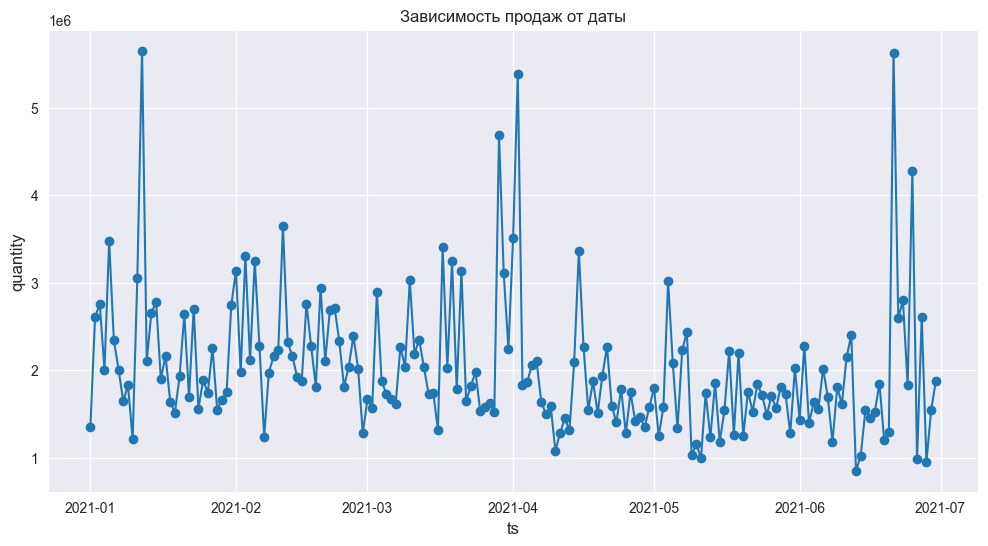

In [43]:
# Нарисуем график зависимости продаж от даты
plot_df = sales_df.copy(deep=True).groupby("ds").agg({"quantity": "sum"}).reset_index()
# Конвертируем колонку в datetime
plot_df["ts"] = pd.to_datetime(plot_df["ds"].astype(str))

plt.figure(figsize=(12, 6))
plt.plot(plot_df["ts"], plot_df["quantity"], marker="o")
plt.xlabel("ts", fontsize=12)
plt.ylabel("quantity", fontsize=12)
plt.title("Зависимость продаж от даты", fontsize=12)
plt.show()

<font color="red">Спрос может падать/расти в связи с промо, праздниками, сезонностью, поэтому следует использовать эти данные в обучении модели.</font>

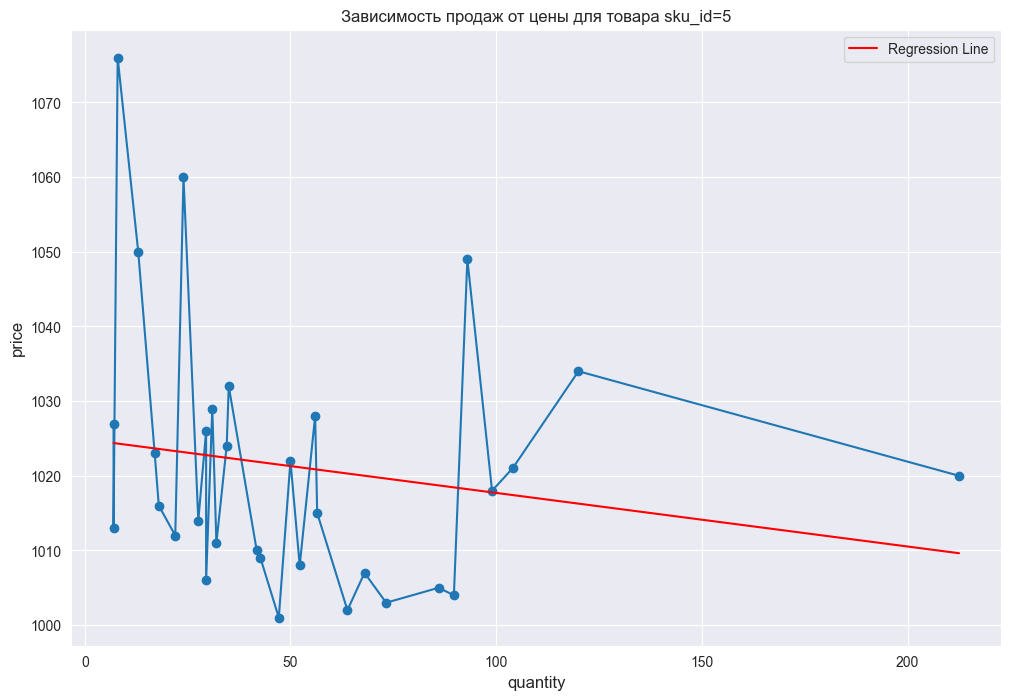

In [44]:
# Построим зависимость продаж от цены для одного товара
SKU_ID = 5
plot_df = sales_df.copy(deep=True)
plot_df = plot_df[plot_df["sku_id"] == SKU_ID]

# Считаем среднее количество продаж для цены, сортируем для построения кривой эластичности
plot_df = plot_df.groupby("price").agg({"quantity": "mean"}).reset_index()
plot_df = plot_df.sort_values("quantity")

# Тренируем линейную регрессию для аппроксимирующей линии
slope, intercept = np.polyfit(plot_df["quantity"], plot_df["price"], 1)
line = slope * plot_df["quantity"] + intercept

plt.figure(figsize=(12, 8))
plt.plot(plot_df["quantity"], plot_df["price"], marker="o")
plt.plot(plot_df["quantity"], line, color="red", label="Regression Line")
plt.ylabel("price", fontsize=12)
plt.xlabel("quantity", fontsize=12)
plt.title(f"Зависимость продаж от цены для товара sku_id={SKU_ID}", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

<font color="red">Количество проданного товара падает с ростом цен, что отражает закон спроса: чем выше цена, тем ниже спрос.</font>

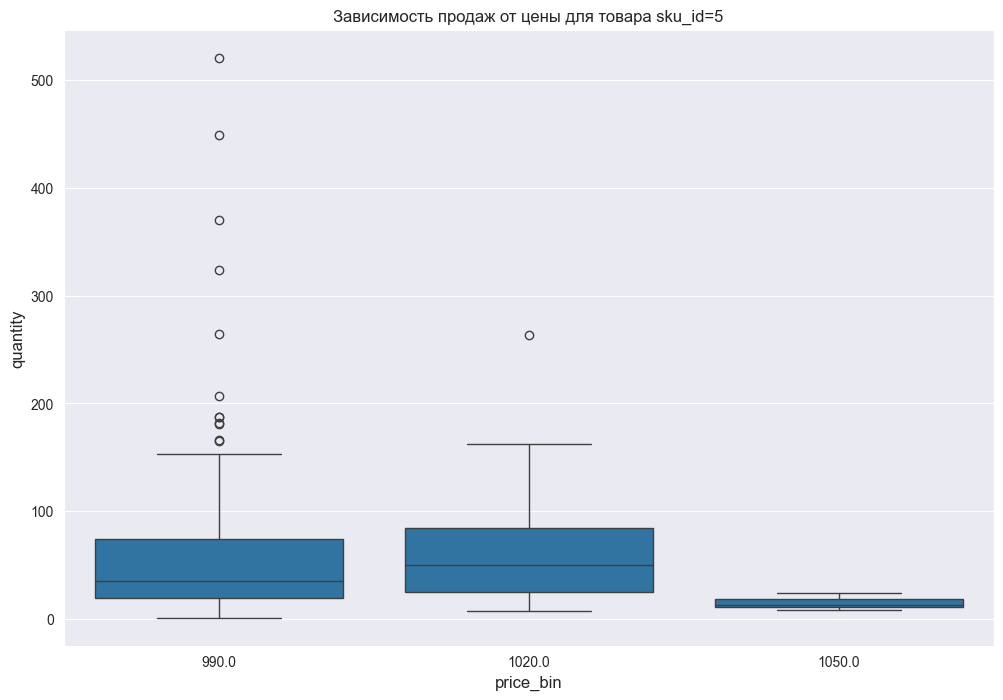

In [45]:
# Нарисуем боксплоты для зависимости продаж от цены для одного товара
SKU_ID = 5
plot_df = sales_df.copy(deep=True)
plot_df = plot_df[plot_df["sku_id"] == SKU_ID]

# Бинаризуем цены, чтобы посчитать средние продажи для бина
BIN_SIZE = 30
min_price = int(plot_df["price"].min())
bin_start = min_price - (min_price % BIN_SIZE)
bin_end = int(plot_df["price"].max()) + BIN_SIZE
bins = range(bin_start, bin_end, BIN_SIZE)
plot_df["price_bin"] = pd.cut(
    plot_df["price"], bins=bins, labels=bins[:-1], right=False
).astype("float")

plt.figure(figsize=(12, 8))
sns.boxplot(x="price_bin", y="quantity", data=plot_df)
plt.ylabel("quantity", fontsize=12)
plt.xlabel("price_bin", fontsize=12)
plt.title(f"Зависимость продаж от цены для товара sku_id={SKU_ID}", fontsize=12)
plt.show()

<font color="red">Медиана количества проданного товара не отражает по-хорошему закон спроса. Возможно, в данных много выбросов - нужно с ними поработать.</font>

### 1.2.2 Сборка данных

In [46]:
# Джойним все данные в единый датасет
orig_df = sales_df.copy(deep=True)
orig_df = orig_df.merge(categories_df, on=["sku_id"])
orig_df = orig_df.merge(dates_df, on=["ds"])
orig_df.head()

,sku_id,price,quantity,ds,group_1,group_2,commission,promo,holiday
0,208,1074.0,15391.0,20210101,100000,100004,0.12,no,Новый год
1,76,1014.0,7.0,20210101,100008,100032,0.10,no,Новый год
2,84,1456.0,2005.0,20210101,100011,100034,0.20,no,Новый год
3,168,1014.0,2124.0,20210101,100001,100029,0.12,no,Новый год
4,92,1032.0,3214.0,20210101,100008,100032,0.10,no,Новый год


### 1.2.3 Преобразование данных

In [47]:
from typing import List, Tuple

# Добавляем новые фичи (окна, сезонные фичи)


# Расчет оконных функций
def calc_rolling_window(
    df: pd.DataFrame,
    window: int,
    col: str,
    lvl: str,
    shift: int,
) -> pd.DataFrame:
    df = df.sort_values(["ds", lvl])
    df["ts"] = pd.to_datetime(df["ds"].astype(str))
    df["col"] = df[col]
    rolling_df = df.set_index("ts")
    rolling_df = (
        rolling_df.groupby([lvl], group_keys=True)["col"]
        # используем shift, так как потом нам нужно предсказывать на N дней вперед:
        # для однородности датасета используем сдвиг на кол-во дат в предсказании
        .apply(
            lambda x: x.asfreq("1D")
            .rolling(window=window, closed="left", min_periods=0)
            .mean()
            .shift(shift)
        )
        .reset_index()
        .rename(columns={"col": f"rolling_{col}_w_{window}"})
    )
    df = df.merge(rolling_df, how="left", on=[lvl, "ts"])
    df = df.drop(columns=["ts", "col"])
    return df


# Функция для преобразования данных
def postprocess_transform(
    df: pd.DataFrame,
    norms: List[Tuple[str, str]],
    roll_cols: List[str],
    windows: List[int],
    dropna_cols: List[str],
    lvl: str,
    shift: int,
):
    # new features
    for window in windows:
        for col in roll_cols:
            logger.info(f"Rolling window={window} days for col `{col}`")
            df = calc_rolling_window(
                df=df, window=window, col=col, lvl=lvl, shift=shift
            )

    # normalisation
    # нормализация даст сигнал модели об изменении признаков: если изменилась цена, то к какому изменению спроса это привело?
    for col1, col2 in norms:
        logger.info(f"Normalizing `{col1}` / `{col2}`")
        df[col1] = df[col1] / (
            df[col2] + 1e-10
        )  # добавляем epsilon, чтобы не было деления на 0

    # postprocessing
    # для однородности данных удаляем первые даты, по которым собирались окна не по полным данным
    disadvantaged_ds_list = sorted(df["ds"].unique())[: max(shift, max(windows))]
    df = df[~df["ds"].isin(disadvantaged_ds_list)]

    df = df.dropna(subset=dropna_cols)
    df = df.round(2)
    df = df.sort_values(["ds", lvl])
    return df


# Функция для преобразования данных с параметрами для удобства короткого вызова
def create_features(df: pd.DataFrame, dropna_cols: List[str], W: int) -> pd.DataFrame:
    df["day_of_week"] = pd.DatetimeIndex(df["ds"]).day_of_week
    df = postprocess_transform(
        df=df,
        norms=[
            ("quantity", f"rolling_quantity_w_{W}"),
            ("rolling_quantity_w_1", f"rolling_quantity_w_{W}"),
            ("rolling_quantity_w_7", f"rolling_quantity_w_{W}"),
            ("rolling_quantity_w_14", f"rolling_quantity_w_{W}"),
            ("rolling_quantity_w_21", f"rolling_quantity_w_{W}"),
            ("price", f"rolling_price_w_{W}"),
            ("rolling_price_w_1", f"rolling_price_w_{W}"),
            ("rolling_price_w_7", f"rolling_price_w_{W}"),
            ("rolling_price_w_14", f"rolling_price_w_{W}"),
            ("rolling_price_w_21", f"rolling_price_w_{W}"),
        ],
        roll_cols=["quantity", "price"],
        dropna_cols=dropna_cols,
        windows=[1, 7, 14, 21, 28],
        lvl="sku_id",
        shift=14,
    )
    return df

In [48]:
# размер окна, на которое нормализуем признаки
# например, нормализуем цену на среднеюю цену за 28 дней
W = 28
df = create_features(df=orig_df, dropna_cols=["quantity", "price"], W=W)
df.head()

INFO:model:Rolling window=1 days for col `quantity`
INFO:model:Rolling window=1 days for col `price`
INFO:model:Rolling window=7 days for col `quantity`
INFO:model:Rolling window=7 days for col `price`
INFO:model:Rolling window=14 days for col `quantity`
INFO:model:Rolling window=14 days for col `price`
INFO:model:Rolling window=21 days for col `quantity`
INFO:model:Rolling window=21 days for col `price`
INFO:model:Rolling window=28 days for col `quantity`
INFO:model:Rolling window=28 days for col `price`
INFO:model:Normalizing `quantity` / `rolling_quantity_w_28`
INFO:model:Normalizing `rolling_quantity_w_1` / `rolling_quantity_w_28`
INFO:model:Normalizing `rolling_quantity_w_7` / `rolling_quantity_w_28`
INFO:model:Normalizing `rolling_quantity_w_14` / `rolling_quantity_w_28`
INFO:model:Normalizing `rolling_quantity_w_21` / `rolling_quantity_w_28`
INFO:model:Normalizing `price` / `rolling_price_w_28`
INFO:model:Normalizing `rolling_price_w_1` / `rolling_price_w_28`
INFO:model:Normaliz

,sku_id,price,quantity,ds,group_1,group_2,commission,promo,holiday,day_of_week,rolling_quantity_w_1,rolling_price_w_1,rolling_quantity_w_7,rolling_price_w_7,rolling_quantity_w_14,rolling_price_w_14,rolling_quantity_w_21,rolling_price_w_21,rolling_quantity_w_28,rolling_price_w_28
5704,1,0.95,0.42,20210129,100000,100000,0.12,no,no,4,0.86,1.05,0.87,1.01,1.0,1.0,1.0,1.0,581.00,1057.75
5705,3,1.06,0.78,20210129,100000,100000,0.10,no,no,4,0.32,0.95,1.12,1.01,1.0,1.0,1.0,1.0,407.36,1069.07
5706,4,0.96,0.11,20210129,100002,100002,0.12,no,no,4,0.28,0.99,1.54,0.99,1.0,1.0,1.0,1.0,223.43,1053.21
5707,5,1.00,0.85,20210129,100003,100003,0.10,no,no,4,1.33,1.00,1.85,1.00,1.0,1.0,1.0,1.0,84.85,1004.62
5708,6,0.91,1.38,20210129,100000,100004,0.20,no,no,4,0.21,0.97,0.64,0.99,1.0,1.0,1.0,1.0,2795.23,1119.08


<font color="red">Получили данные, которые можно использовать в трейне модели спроса.</font>

### 1.2.4 Деление на train и test: Time Series Cross Validation

#### Для чего?
- предотвращает переобучение
- оценивает модель надежным способом
- <b>не использует значения из будущего для прогнозирования значений в прошлом</b>

Варианты TimeSeries кросс-валидации:
- TimeSeriesSplit
- BlockingTimeSeriesSplit

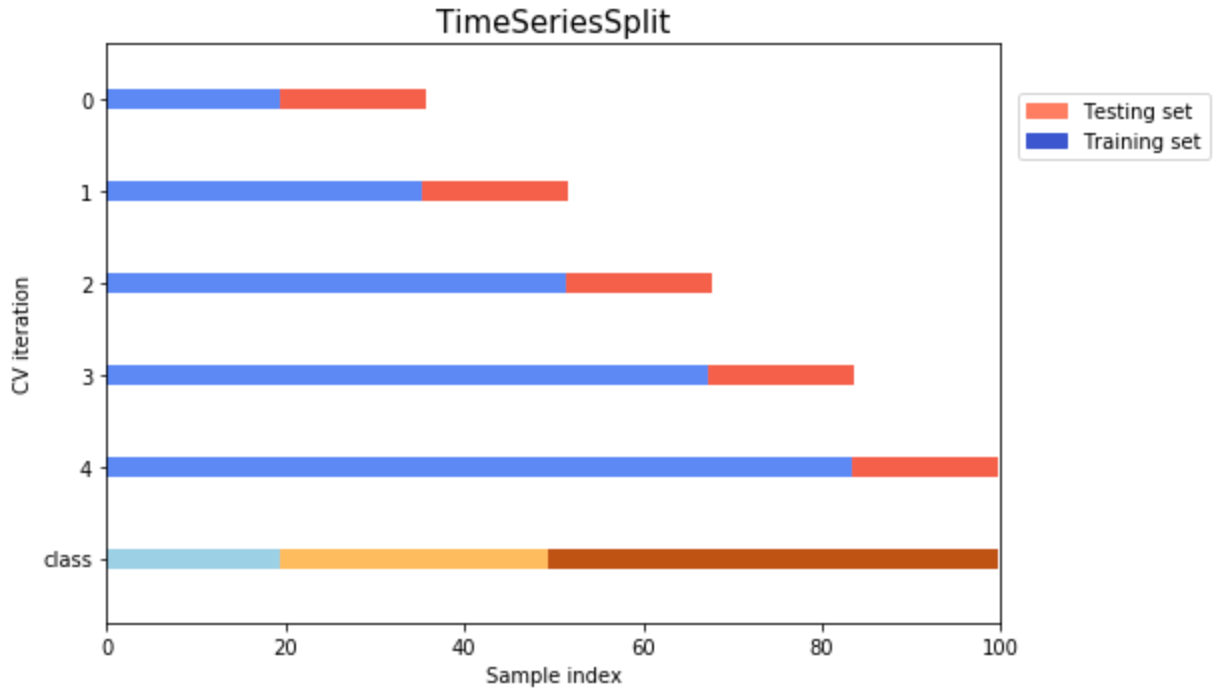

In [49]:
Image("./images/time_series_split.png", width=500, height=200)

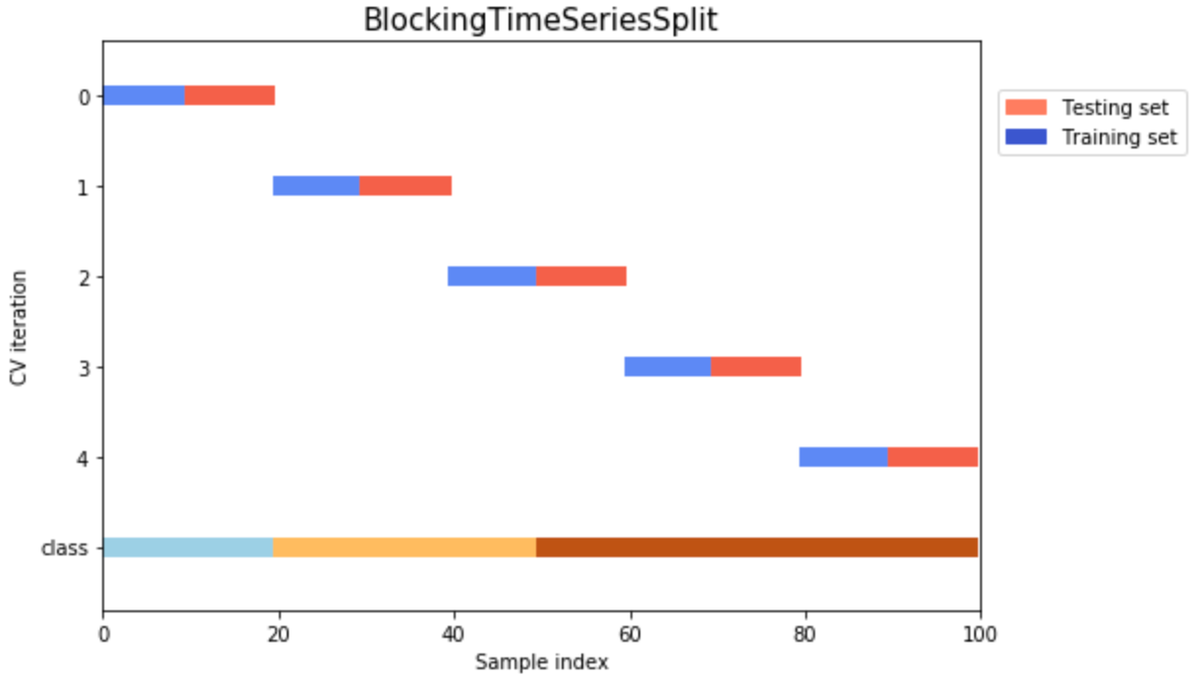

In [50]:
Image("./images/blocking_time_series_split.png", width=500, height=200)

In [51]:
# Возьмем для оценки 1 вариант кросс-валидации

from sklearn.model_selection import TimeSeriesSplit
from typing import Tuple


def get_dfs(
    df: pd.DataFrame,
    n_splits: int,
    test_size: int,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Возвращает 3 датасета: трейн, вал, тест
    """
    # Уникальные даты в датасете
    dates = pd.Series(sorted(df["ds"].unique()))
    # Создание объекта TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    # Проход по разделениям
    for split_id, (train_idxs, test_idxs) in enumerate(tscv.split(dates)):
        train_dates = dates.iloc[train_idxs]
        test_dates = dates.iloc[test_idxs]
        val_dates = train_dates[-test_size:]
        train_dates = train_dates[:-test_size]

        logger.info(f"===== SPLIT {split_id} =====")
        logger.info(
            f"Train: {train_dates.min()} - {train_dates.max()}, size: {train_dates.shape[0]}"
        )
        logger.info(
            f"Validation: {val_dates.min()} - {val_dates.max()}, size: {val_dates.shape[0]}"
        )
        logger.info(
            f"Test: {test_dates.min()} - {test_dates.max()}, size: {test_dates.shape[0]}"
        )

        train_df = df[df["ds"].isin(train_dates)]
        val_df = df[df["ds"].isin(val_dates)]
        test_df = df[df["ds"].isin(test_dates)]
        yield train_df, val_df, test_df


TEST_SIZE = 14
N_SPLITS = 3

for train_df, val_df, test_df in get_dfs(
    df=df,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
):
    pass

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210129 - 20210505, size: 97
INFO:model:Validation: 20210506 - 20210519, size: 14
INFO:model:Test: 20210520 - 20210602, size: 14
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210129 - 20210519, size: 111
INFO:model:Validation: 20210520 - 20210602, size: 14
INFO:model:Test: 20210603 - 20210616, size: 14
INFO:model:===== SPLIT 2 =====
INFO:model:Train: 20210129 - 20210602, size: 125
INFO:model:Validation: 20210603 - 20210616, size: 14
INFO:model:Test: 20210617 - 20210630, size: 14


## 1.3 Имплементация подхода

В качестве базовой модели имплементируем градиентный бустинг, так как:
- показывает высокие результаты
- поддерживает разные типы данных из коробки
- легко обрабатывает NaNs
- управляет переобучением через параметры
- контролирует закон спроса через ограничения монотонности
- …
  
Однако, в реальном мире следует рассмотреть разные варианты моделей, так как у градиентного бустинга есть свои минусы, например, слабая экстраполяция (не учитывается рост спроса)

In [52]:
# Объявляем фичи и параметры для обучения
FLT_FEATURES = [
    "price",
    "rolling_quantity_w_1",
    "rolling_quantity_w_7",
    "rolling_quantity_w_14",
    "rolling_quantity_w_21",
    "rolling_price_w_1",
    "rolling_price_w_7",
    "rolling_price_w_14",
    "rolling_price_w_21",
]
CAT_FEATURES = [
    "group_1",
    "group_2",
    "promo",
    "holiday",
    "day_of_week",
]
TARGET = "quantity"
TRAIN_PARAMS = {
    "task_type": "CPU",
    "verbose": 100,
    "random_seed": 0,
    "iterations": 1000,
    "loss_function": "Quantile:alpha=0.5",
    # выставляем ограничения на монотонность для поддержания закона спроса: чем больше цена, тем меньше спрос
    "monotone_constraints": [
        -1 if "price" in feature else 0 for feature in FLT_FEATURES
    ],
    # хотим, чтобы спрос в большей степени зависел от цены => ставим фиче price больший вес
    "feature_weights": "price:2.0",
    "metric_period": 100,
    "early_stopping_rounds": 100,
    "eval_metric": "MAPE",
}

In [53]:
from catboost import CatBoost, Pool
from typing import List, Dict, Any, Optional


# Функция для преобразования данных на вход Catboost
def prepare_pool(
    df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    target: Optional[str] = None,
) -> Pool:
    data = df[flt_features + cat_features]
    pool = Pool(
        data=data,
        label=df[target] if target is not None else None,
        cat_features=cat_features,
    )
    return pool


# Функция для тренировки модели спроса
def train_model(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    target: str,
    train_params: Dict[str, Any],
) -> CatBoost:
    train_data = train_df[flt_features + cat_features]
    train_pool = prepare_pool(
        df=train_df,
        flt_features=flt_features,
        cat_features=cat_features,
        target=target,
    )
    val_pool = prepare_pool(
        df=val_df,
        flt_features=flt_features,
        cat_features=cat_features,
        target=target,
    )
    model = CatBoost(params=train_params).fit(X=train_pool, eval_set=val_pool)
    return model


# Функция для предсказания спроса с обученной моделью
def predict(
    df: pd.DataFrame,
    model: CatBoost,
    flt_features: List[str],
    cat_features: List[str],
    target: str,
) -> List[float]:
    pool = prepare_pool(
        df=df,
        flt_features=flt_features,
        cat_features=cat_features,
    )
    preds = model.predict(data=pool)
    return preds

## 1.4 Оценка

### 1.4.1 Подсчет офлайн метрик

In [54]:
from typing import List, Dict, Any, Callable, Optional


# Пайплайн для валидации модели
def run_pipeline(
    df: pd.DataFrame,
    flt_features: List[str],
    cat_features: List[str],
    train_params: Dict[str, Any],
    target: str,
    n_splits: int,
    test_size: int,
) -> float:
    mapes = []
    for train_df, val_df, test_df in get_dfs(
        df=df,
        n_splits=n_splits,
        test_size=test_size,
    ):
        # Тренируем модель
        model = train_model(
            train_df=train_df,
            val_df=val_df,
            flt_features=flt_features,
            cat_features=cat_features,
            target=target,
            train_params=train_params,
        )
        # Смотрим на важность фичей
        logger.info(model.get_feature_importance(prettified=True).head(10))
        # Предсказываем с помощью обученной модели
        test_df["pred_quantity"] = predict(
            df=test_df,
            model=model,
            flt_features=flt_features,
            cat_features=cat_features,
            target=target,
        )
        # считаем качество
        # лучше считать качество с учетом постпроцессинга (включая clip), но сейчас этим пренебрежём
        mape = calculate_mape(
            df=test_df,
            true="quantity",
            pred="pred_quantity",
        )
        mapes.append(mape)
        logger.info(f"MAPE: {mape}")

    mean_mape = np.mean(mapes)
    logger.info(f"Mean MAPE: {mean_mape}")
    return mean_mape, model, train_df, val_df, test_df

In [55]:
mape, model, train_df, val_df, test_df = run_pipeline(
    df=df,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    train_params=TRAIN_PARAMS,
    target=TARGET,
    n_splits=N_SPLITS,
    test_size=TEST_SIZE,
)

INFO:model:===== SPLIT 0 =====
INFO:model:Train: 20210129 - 20210505, size: 97
INFO:model:Validation: 20210506 - 20210519, size: 14
INFO:model:Test: 20210520 - 20210602, size: 14


0:	learn: 0.3927480	test: 0.3798353	best: 0.3798353 (0)	total: 27ms	remaining: 27s
100:	learn: 0.3875549	test: 0.3775437	best: 0.3775437 (100)	total: 2.25s	remaining: 20s
200:	learn: 0.3857708	test: 0.3785965	best: 0.3773529 (123)	total: 4.46s	remaining: 17.7s


INFO:model:              Feature Id  Importances
0   rolling_quantity_w_7    17.911748
1                  promo    17.211872
2            day_of_week    12.474422
3  rolling_quantity_w_14    12.299579
4                group_2     8.822097
5                  price     7.967572
6                group_1     7.185741
7   rolling_quantity_w_1     6.723018
8  rolling_quantity_w_21     6.203431
9                holiday     2.246475
INFO:model:MAPE: 1.2703948833651506
INFO:model:===== SPLIT 1 =====
INFO:model:Train: 20210129 - 20210519, size: 111
INFO:model:Validation: 20210520 - 20210602, size: 14
INFO:model:Test: 20210603 - 20210616, size: 14


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.377352852
bestIteration = 123

Shrink model to first 124 iterations.
0:	learn: 0.3912102	test: 0.3765137	best: 0.3765137 (0)	total: 13.1ms	remaining: 13.1s


100:	learn: 0.3860066	test: 0.3728963	best: 0.3728897 (99)	total: 2.65s	remaining: 23.6s
200:	learn: 0.3844692	test: 0.3722357	best: 0.3722275 (199)	total: 5.44s	remaining: 21.6s
300:	learn: 0.3833599	test: 0.3722750	best: 0.3722030 (205)	total: 9.85s	remaining: 22.9s


INFO:model:              Feature Id  Importances
0   rolling_quantity_w_7    17.994788
1                  promo    16.971804
2            day_of_week    12.420382
3  rolling_quantity_w_14    11.630468
4                  price    10.634545
5                group_1     7.918830
6  rolling_quantity_w_21     7.772317
7                group_2     6.240217
8   rolling_quantity_w_1     4.521968
9                holiday     2.584031
INFO:model:MAPE: 1.2712815089225646
INFO:model:===== SPLIT 2 =====
INFO:model:Train: 20210129 - 20210602, size: 125
INFO:model:Validation: 20210603 - 20210616, size: 14
INFO:model:Test: 20210617 - 20210630, size: 14


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3722030231
bestIteration = 205

Shrink model to first 206 iterations.


0:	learn: 0.3882186	test: 0.3796158	best: 0.3796158 (0)	total: 24.8ms	remaining: 24.8s
100:	learn: 0.3840158	test: 0.3795744	best: 0.3789756 (78)	total: 6.25s	remaining: 55.6s


INFO:model:              Feature Id  Importances
0   rolling_quantity_w_7    24.936859
1                  promo    17.640893
2  rolling_quantity_w_14    13.149979
3            day_of_week    11.610703
4                  price     9.617319
5  rolling_quantity_w_21     9.035414
6   rolling_quantity_w_1     3.830894
7                group_2     3.324889
8                group_1     3.031507
9                holiday     2.908830
INFO:model:MAPE: 1.3030657322936567
INFO:model:Mean MAPE: 1.2815807081937907


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3789756073
bestIteration = 78

Shrink model to first 79 iterations.


<font color="red">MAPE не прекрасен, но мы посмотрели самую простую модель с маленьким количеством фичей - есть над чем поработать.</font>

### 1.4.2 Интерпретация фичей

Если не устраивает качество модели, можно дебажить с помощью shap values , подробнее [тут](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

In [56]:
import shap

shap.initjs()

In [57]:
explainer = shap.TreeExplainer(model)
shap_test_df = test_df[FLT_FEATURES + CAT_FEATURES]
shap_values = explainer(shap_test_df)

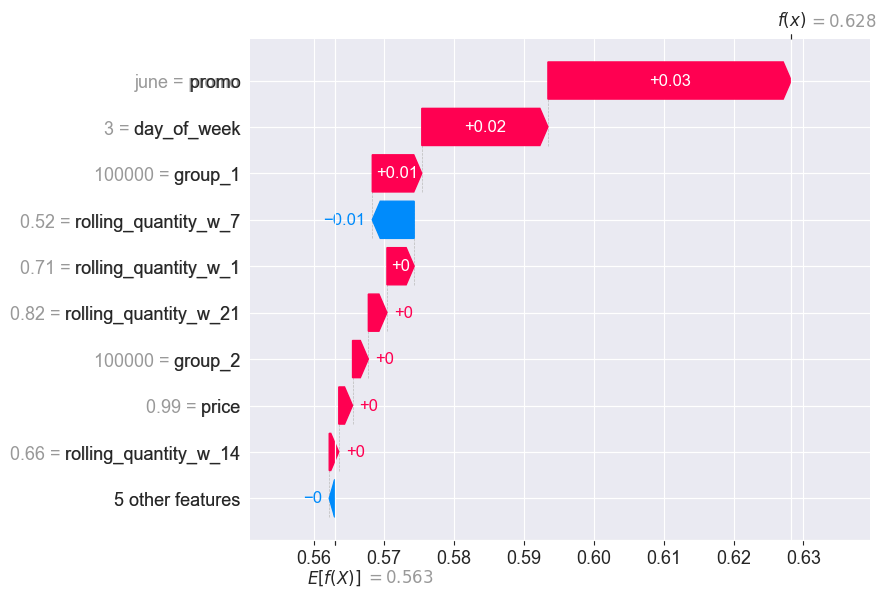

In [58]:
SKU_ID = 5
idx = test_df[test_df["sku_id"] == SKU_ID].reset_index()
shap.plots.waterfall(shap_values[idx.index[0]])
# Возможно модель переобучилась на "promo" и этот признак стоит исключить

<font color="red">По графику можно увидеть, насколько сильно каждая фича повлияла на предсказание.</font>

### 1.4.3 Визуализация предсказаний

Для дебага можно визуализировать данные удобным способом, например, изображение TimeSeries может помочь обнаружить недостатки модели

In [59]:
def plot_time_series(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    sku_id: int,
) -> None:
    # Сборка данных
    sku_train_df = train_df[train_df["sku_id"] == sku_id]
    sku_val_df = val_df[val_df["sku_id"] == sku_id]
    sku_test_df = test_df[test_df["sku_id"] == sku_id]

    train = sku_train_df[["quantity", "ds"]].set_index("ds")
    val = sku_val_df[["quantity", "ds"]].set_index("ds")
    test = sku_test_df[["quantity", "ds"]].set_index("ds")
    pred = sku_test_df[["pred_quantity", "ds"]].set_index("ds")

    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(train, label="Train")
    plt.plot(val, label="Validation")
    plt.plot(test, label="Test")
    plt.plot(pred, label="Prediction")
    plt.title(f"Time Series Train/Val/Test/Pred for sku_id={sku_id}")
    plt.xlabel("ds")
    plt.ylabel("quantity")
    plt.legend()
    plt.grid(True)
    plt.xticks(
        [
            ds if ds.endswith("01") else ""
            for ds in sku_train_df["ds"].tolist()
            + sku_val_df["ds"].tolist()
            + sku_test_df["ds"].tolist()
        ]
    )
    plt.show()

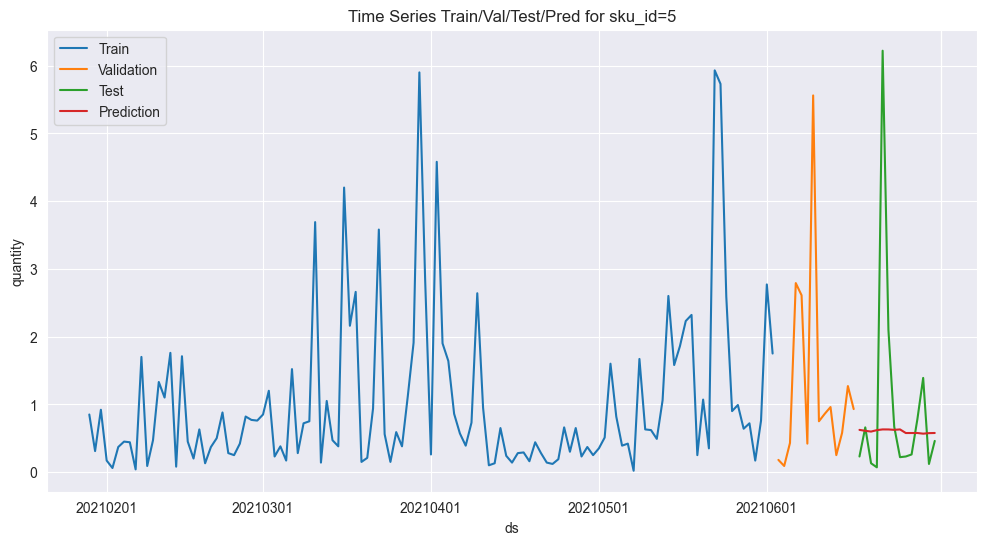

In [60]:
plot_time_series(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    sku_id=5,
)

<font color="red">На графике можно увидеть, что модель хорошо улавливает предсказание медианы, но есть много моментов, над которыми стоит поработать, например, через добавление новых признаков, предобработкой данных, использование коэффициентов для учитывания роста спроса со временем.</font>

# 2. Спрос

Вспомним про наши условия и ограничения:
- Нужно выставить цены на <b>2 недели</b> вперед с <b>01.07.2021</b> по <b>14.07.2021</b>
- Цены можно менять <b>+/-10%</b> от текущей цены

В этом разделе мы пременим обученную модель для предсказания спроса для разных цен.

In [67]:
START_DS, END_DS = "20210701", "20210714"

# Находим текущие цены
pred_df = sales_df.copy(deep=True)[["sku_id", "price", "ds"]]
pred_df = pred_df.sort_values(by=["sku_id", "ds"])
pred_df = pred_df.groupby("sku_id").last().reset_index()
pred_df = pred_df.drop(columns=["ds"])

# Наджойниваем даты для предсказания
pred_dates_df = dates_df[dates_df["ds"].between(START_DS, END_DS)]
pred_df = pred_df.join(pred_dates_df, how="cross")

pred_df

,sku_id,price,promo,holiday,ds
0,1,1043.0,no,no,20210708
1,1,1043.0,no,no,20210709
2,1,1043.0,no,no,20210710
3,1,1043.0,no,no,20210711
4,1,1043.0,no,no,20210712
...,...,...,...,...,...
3159,413,1011.0,no,no,20210703
3160,413,1011.0,no,no,20210704
3161,413,1011.0,no,no,20210705
3162,413,1011.0,no,no,20210706


In [68]:
# Конкатим с историческими данными, чтобы посчитать оконные фичи
cols = pred_df.columns.tolist() + ["quantity"]
pred_df["quantity"] = None
pred_df = pd.concat([orig_df.copy(deep=True)[cols], pred_df[cols]])

pred_df

,sku_id,price,promo,holiday,ds,quantity
0,208,1074.0,no,Новый год,20210101,15391.0
1,76,1014.0,no,Новый год,20210101,7.0
2,84,1456.0,no,Новый год,20210101,2005.0
3,168,1014.0,no,Новый год,20210101,2124.0
4,92,1032.0,no,Новый год,20210101,3214.0
...,...,...,...,...,...,...
3159,413,1011.0,no,no,20210703,NaN
3160,413,1011.0,no,no,20210704,NaN
3161,413,1011.0,no,no,20210705,NaN
3162,413,1011.0,no,no,20210706,NaN


In [70]:
orig_df

,sku_id,price,quantity,ds,group_1,group_2,commission,promo,holiday,day_of_week
0,208,1074.0,15391.0,20210101,100000,100004,0.12,no,Новый год,4
1,76,1014.0,7.0,20210101,100008,100032,0.10,no,Новый год,4
2,84,1456.0,2005.0,20210101,100011,100034,0.20,no,Новый год,4
3,168,1014.0,2124.0,20210101,100001,100029,0.12,no,Новый год,4
4,92,1032.0,3214.0,20210101,100008,100032,0.10,no,Новый год,4
...,...,...,...,...,...,...,...,...,...,...
36779,167,1072.0,243.0,20210402,100000,100031,0.10,no,no,4
36780,95,1050.0,414.0,20210402,100005,100028,0.20,no,no,4
36781,228,1130.0,2546.0,20210402,100009,100025,0.20,no,no,4
36782,79,1005.0,1843.0,20210402,100002,100002,0.12,no,no,4


In [41]:
START_DS, END_DS = "20210701", "20210714"

# Находим текущие цены
pred_df = sales_df.copy(deep=True)[["sku_id", "price", "ds"]]
pred_df = pred_df.sort_values(by=["sku_id", "ds"])
pred_df = pred_df.groupby("sku_id").last().reset_index()
pred_df = pred_df.drop(columns=["ds"])

# Наджойниваем даты для предсказания
pred_dates_df = dates_df[dates_df["ds"].between(START_DS, END_DS)]
pred_df = pred_df.join(pred_dates_df, how="cross")

# Конкатим с историческими данными, чтобы посчитать оконные фичи
cols = pred_df.columns.tolist() + ["quantity"]
pred_df["quantity"] = None
pred_df = pd.concat([orig_df.copy(deep=True)[cols], pred_df[cols]])

# Считаем фичи
pred_df = create_features(df=pred_df, dropna_cols=["price"], W=W)
pred_df = pred_df[pred_df["ds"].between(START_DS, END_DS)]

# Наджойниваем категории и комиссии
pred_df = pred_df.merge(categories_df, how="inner", on=["sku_id"])

# Рассчитываем новые цены с учетом "+/-10% от текущей цены"
# Если у вас есть ограничения на цены, то как раз здесь их можно применить
discounts_df = pd.DataFrame({"discount": np.arange(-0.1, 0.11, 0.05).round(2).tolist()})
pred_df = pred_df.join(discounts_df, how="cross")
pred_df["price"] = (
    (
        pred_df["price"] * pred_df[f"rolling_price_w_{W}"]
        + pred_df["price"] * pred_df[f"rolling_price_w_{W}"] * pred_df["discount"]
    )
    / pred_df[f"rolling_price_w_{W}"]
).round(2)

# предсказываем спрос с помощью модели
pred_df["quantity"] = predict(
    df=pred_df,
    model=model,
    flt_features=FLT_FEATURES,
    cat_features=CAT_FEATURES,
    target=TARGET,
)

# восстанавливаем реальные значения price и quantity
pred_df["quantity"] = pred_df["quantity"] * pred_df["rolling_quantity_w_28"]
pred_df["price"] = pred_df["price"] * pred_df["rolling_price_w_28"]

# quantity не может быть меньше 0
pred_df["quantity"] = np.clip(pred_df["quantity"], a_min=0.0, a_max=None)
# если у вас есть ограничения на сток, то как раз здесь их можно применить

pred_df.head()

INFO:model:Rolling window=1 days for col `quantity`
INFO:model:Rolling window=1 days for col `price`
INFO:model:Rolling window=7 days for col `quantity`
INFO:model:Rolling window=7 days for col `price`
INFO:model:Rolling window=14 days for col `quantity`
INFO:model:Rolling window=14 days for col `price`
INFO:model:Rolling window=21 days for col `quantity`
INFO:model:Rolling window=21 days for col `price`
INFO:model:Rolling window=28 days for col `quantity`
INFO:model:Rolling window=28 days for col `price`
INFO:model:Normalizing `quantity` / `rolling_quantity_w_28`
INFO:model:Normalizing `rolling_quantity_w_1` / `rolling_quantity_w_28`
INFO:model:Normalizing `rolling_quantity_w_7` / `rolling_quantity_w_28`
INFO:model:Normalizing `rolling_quantity_w_14` / `rolling_quantity_w_28`
INFO:model:Normalizing `rolling_quantity_w_21` / `rolling_quantity_w_28`
INFO:model:Normalizing `price` / `rolling_price_w_28`
INFO:model:Normalizing `rolling_price_w_1` / `rolling_price_w_28`
INFO:model:Normaliz

,sku_id,price,promo,holiday,ds,quantity,day_of_week,rolling_quantity_w_1,rolling_price_w_1,rolling_quantity_w_7,...,rolling_quantity_w_14,rolling_price_w_14,rolling_quantity_w_21,rolling_price_w_21,rolling_quantity_w_28,rolling_price_w_28,group_1,group_2,commission,discount
0,1,942.1048,no,no,20210701,503.828979,3,1.24,0.99,1.15,...,1.49,1.0,1.1,1.0,924.6,1035.28,100000,100000,0.12,-0.10
1,1,993.8688,no,no,20210701,503.828979,3,1.24,0.99,1.15,...,1.49,1.0,1.1,1.0,924.6,1035.28,100000,100000,0.12,-0.05
2,1,1045.6328,no,no,20210701,503.828979,3,1.24,0.99,1.15,...,1.49,1.0,1.1,1.0,924.6,1035.28,100000,100000,0.12,0.00
3,1,1097.3968,no,no,20210701,500.419124,3,1.24,0.99,1.15,...,1.49,1.0,1.1,1.0,924.6,1035.28,100000,100000,0.12,0.05
4,1,1149.1608,no,no,20210701,498.862055,3,1.24,0.99,1.15,...,1.49,1.0,1.1,1.0,924.6,1035.28,100000,100000,0.12,0.10


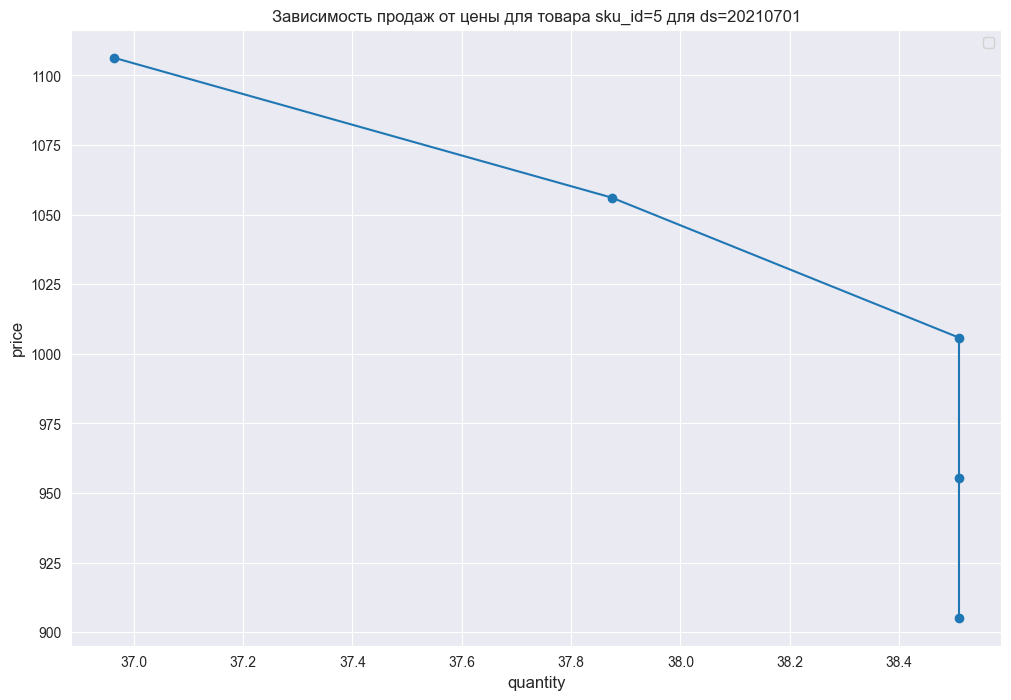

In [42]:
# Изобразим получившуюся кривую эластичности по товару SKU_ID
SKU_ID = 5  # id товара
plot_df = pred_df[(pred_df["sku_id"] == SKU_ID) & (pred_df["ds"] == START_DS)]

plt.figure(figsize=(12, 8))
plt.plot(plot_df["quantity"], plot_df["price"], marker="o")
plt.ylabel("price", fontsize=12)
plt.xlabel("quantity", fontsize=12)
plt.title(
    f"Зависимость продаж от цены для товара sku_id={SKU_ID} для ds={START_DS}",
    fontsize=12,
)
plt.legend()
plt.grid(True)
plt.show()

<font color="red">На графике можно увидеть закон спроса. Спрос меняется быстрее при низких ценах, чем при высоких, но тут хорошо бы еще проверить уверенность модели в предсказании, так как модель может ошибаться, если не встречала таких наценок на истории (если на истории было мало изменений цен - нужно запустить exploration, чтобы получить разнообразные данные для улучшения модели).</font>

# 3. Оптимизация

Цель нашего проекта - максимизация прибыли:
<center>$Margin = commission * price * quantity + discount * price * quantity \rightarrow \max$</center>

Тут мы будем искать лучшие цены под нашу задачу.

In [43]:
# Подсчет метрик
pred_df["margin"] = (
    pred_df["commission"] * pred_df["price"] * pred_df["quantity"]
    + pred_df["discount"] * pred_df["price"] * pred_df["quantity"]
)
pred_df["revenue"] = pred_df["price"] * pred_df["quantity"]
# Нахождение индекса строки с максимальным margin для каждого sku_id по каждому дню
idx = pred_df.groupby(["sku_id", "ds"])["margin"].idxmax()
# Выбор соответствующих строк из исходного датасета
selected_df = pred_df.loc[idx]
selected_df[["sku_id", "price", "discount", "ds"]].head()

,sku_id,price,discount,ds
4,1,1149.1608,0.1,20210701
9,1,1148.2728,0.1,20210702
14,1,1148.4504,0.1,20210703
19,1,1150.5594,0.1,20210704
24,1,1151.5806,0.1,20210705


In [44]:
# Посмотрим распределение скидок
selected_df["discount"].value_counts(normalize=True)

0.1    1.0
Name: discount, dtype: float64

<font color="red">Так как 1) нет ограничений по стокам и ценам товара, 2) нет ограничений на выручку по условию задачи, 3) прибыль считается как процент от выручки, выбирается всегда максимальная наценка для каждого товара. В реальности условия могут быть разные => результат может отличаться.</font>

In [45]:
# Считаем аплифт на предсказаниях
control_margin = pred_df[pred_df["discount"] == 0]["margin"].sum()
control_revenue = pred_df[pred_df["discount"] == 0]["revenue"].sum()

test_margin = selected_df["margin"].sum()
test_revenue = selected_df["revenue"].sum()

print(f"Control margin: {round(control_margin)} руб.")
print(f"Test margin: {round(test_margin)} руб.")
print(f"Uplift: {round(test_margin * 100 / control_margin - 100)} %")

print(f"Control revenue: {round(control_revenue)} руб.")
print(f"Test revenue: {round(test_revenue)} руб.")
print(f"Uplift: {round(test_revenue * 100 / control_revenue - 100)} %")

Control margin: 2208589741 руб.
Test margin: 4109493682 руб.
Uplift: 86 %
Control revenue: 15701015177 руб.
Test revenue: 17078488795 руб.
Uplift: 9 %


<font color="red">Если верить нашей модели, то наш алгоритм будет лучше работать по прибыли и выручке. Это флаг, что если заказчика интересуют только эти метрики, то стоит этот алгоритм вывести в АБ. Однако, чаще всего улучшение одной метрики может привести к ухудшению другой - стоит подумать, какие метрики могли пострадать и посчитать на них аплифт.</font>

# Резюме

- подготовили пайплайн динамического ценообразования (модель, спрос, оптимизизация) через построение модели спроса
- модель (офлайн метрики, данные, имплементация подхода, оценка)
    - выбрали метрику для оценки качества модели
    - обсудили нюансы сборки TimeSeries датасета и TimeSeries кросс-валидацию
    - построили один вариант модели
    - посмотрели несколько способов визуализации данных для дебага
- научились строить датасет для этапа "спрос"
- выбрали оптимальные цены/наценки для максимизации одной метрики без ограничений